# MlOps - Homework 3

Kajetan Sulwiński 151954 <br/>
Mikołaj Marmurowicz 151956

This notebook was created in a tutorial-style, step-by-step manner, with the goal of being as clear and idiot-proof as possible. This is because it was our first time deploying a model on AWS, and we wanted to fully understand each step instead of relying on black-box solutions.

The notebook walks through the entire process, from choosing a lightweight pre-trained model, to deploying it on an AWS EC2 instance and exposing it through an HTTP endpoint. Each step is tested and explained to make the deployment easy to follow and reproduce.

## Step 1/2 - Model choice and local testing

We chose MobileNetV3 Small, a lightweight image classification model that is fast and well suited for CPU inference.

First, we test the model locally to ensure that it works correctly before moving to deployment.

Below is the `service.py` source code:
```python
import bentoml
import torch
from PIL import Image as PILImage
from torchvision import models
from torchvision.models import MobileNet_V3_Small_Weights

@bentoml.service(resources={"cpu": "2"}, traffic={"timeout": 30})
class MobileNetV3SmallService:
    def __init__(self) -> None:
        self.device_id = "cpu"
        self.device = torch.device(self.device_id)
        weights = MobileNet_V3_Small_Weights.DEFAULT
        self.preprocess = weights.transforms()
        self.categories = weights.meta["categories"]
        self.model = models.mobilenet_v3_small(weights=weights).to(self.device)
        self.model.eval()

    @bentoml.api(route="/predict")
    def predict(self, image: PILImage.Image, /) -> dict:
        if image.mode != "RGB":
            image = image.convert("RGB")
        x = self.preprocess(image).unsqueeze(0).to(self.device)
        with torch.no_grad():
            logits = self.model(x)[0]
            probs = torch.softmax(logits, dim=0)
        topk = torch.topk(probs, k=5)
        top5 = [
            {"label": self.categories[int(i)], "score": float(s)}
            for s, i in zip(topk.values.tolist(), topk.indices.tolist())
        ]
        return {"top5": top5}

```

The service is started locally using:
```bash
bentoml serve service.py:MobileNetV3SmallService --port 3000
```

To verify that the model works as expected, we send a test image taken from the CIFAR-10 dataset (sample index 42) and check whether the service returns a valid prediction.

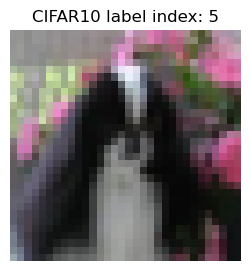

HTTP status: 200
Model response:
{'top5': [{'label': 'Japanese spaniel', 'score': 0.7328197956085205}, {'label': 'cloak', 'score': 0.09763329476118088}, {'label': 'Windsor tie', 'score': 0.08347872644662857}, {'label': 'colobus', 'score': 0.010282733477652073}, {'label': 'overskirt', 'score': 0.006270985584706068}]}


In [ ]:
import io
import requests
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10

URL = "http://127.0.0.1:3000/predict"

ds = CIFAR10(root="./data", train=False, download=True)
img, label = ds[42]

plt.figure(figsize=(3, 3))
plt.imshow(img)
plt.axis("off")
plt.title(f"CIFAR10 label index: {label}")
plt.show()

buf = io.BytesIO()
img.save(buf, format="PNG")
payload = buf.getvalue()

resp = requests.post(
    URL,
    data=payload,
    headers={"Content-Type": "image/png"},
    timeout=30,
)

print("HTTP status:", resp.status_code)
print("Model response:")
print(resp.json())


The model works as expected and is able to predict the correct class with fairly high confidence.

## Step 3 - Preparation for deployment (copying required files to the VM)

First, a `bentofile.yaml` file was created to define the service and its dependencies:
```yaml
service: "service.py:MobileNetV3SmallService"
include:
  - "service.py"
python:
  packages:
    - "bentoml>=1.4.3"
    - "torch"
    - "torchvision"
    - "pillow"

```

Then we turn on the instance - no changes needed yet in terms of security & networking.
Next, the AWS EC2 instance was accessed from PowerShell (with administrator privileges) using the predefined SSH configuration file:
```bash
ssh -F ubuntuawsconfig MlOps-Mikolaj
```

Finally, only the required files were uploaded to the VM using scp from a separate PowerShell session:
```bash
scp -F ubuntuawsconfig service.py bentofile.yaml MlOps-Mikolaj:~/hw3/
```

## Step 4 - Installation of needed applications and libraries

First, Docker was installed on the EC2 virtual machine:
```bash 
sudo apt-get update
sudo apt-get install -y docker.io
sudo usermod -aG docker $USER
newgrp docker
docker --version
```

Next, Python and the required packages for building the BentoML container were installed:
```bash
sudo apt-get install -y python3-venv python3-pip
python3 -m venv .venv
source .venv/bin/activate
pip install -U pip
pip install "bentoml>=1.4.3"
pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu
pip install pillow
bentoml --version
```

After the environment was set up, the BentoML bundle was built using:
```bash
bentoml build
```

The bundle was then containerized into a Docker image (full tag can be obtained after the BentoML build is finished):
```bash
export DOCKER_BUILDKIT=0
export COMPOSE_DOCKER_CLI_BUILD=0
bentoml containerize < FULL_TAG > -t hw3-mobilenet:latest
```

During this step, build-related errors occurred due to Docker configuration issues. These were resolved by adjusting the Docker build settings, after which the containerization completed successfully.

## Step 5 - Running the docker container

After containerization, the Docker container was started on port 3000.
The --restart unless-stopped option was used to ensure that the service automatically restarts if the instance is rebooted:
```bash
docker run -d \
  --name hw3_srv \
  --restart unless-stopped \
  -p 3000:3000 \
  hw3-mobilenet:latest \
  serve
```

At this point, the model serving application was running inside a Docker container on the AWS EC2 instance and ready to accept inference requests.

## Step 7 - adjusted firewall & networking rules on the AWS platform

In order to make the deployed service accessible from outside the EC2 instance, the inbound firewall rules of the associated Security Group had to be updated.

A new inbound rule was added to allow TCP traffic on port 3000, which is the port used by the BentoML service.

After applying this change, the HTTP endpoint exposed by the Docker container became reachable from an external machine, allowing the deployment to be tested from the local environment.

## Step 8 - Testing

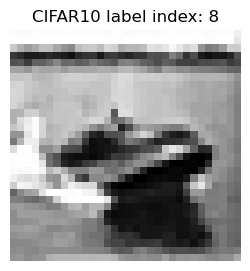

URL: http://13.49.246.152:3000/predict
HTTP status: 200
Model response:
{'top5': [{'label': 'speedboat', 'score': 0.24992971122264862}, {'label': 'amphibian', 'score': 0.14290733635425568}, {'label': 'killer whale', 'score': 0.1299644559621811}, {'label': 'steel arch bridge', 'score': 0.08524178713560104}, {'label': 'grey whale', 'score': 0.023027973249554634}]}


In [11]:
import io
import requests
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10

EC2_PUBLIC_IP = "13.49.246.152"
PORT = 3000
URL = f"http://{EC2_PUBLIC_IP}:{PORT}/predict"

ds = CIFAR10(root="./data", train=False, download=True)
img, label = ds[150]

plt.figure(figsize=(3, 3))
plt.imshow(img)
plt.axis("off")
plt.title(f"CIFAR10 label index: {label}")
plt.show()

buf = io.BytesIO()
img.save(buf, format="PNG")
payload = buf.getvalue()

resp = requests.post(
    URL,
    data=payload,
    headers={"Content-Type": "image/png"},
    timeout=30,
)

print("URL:", URL)
print("HTTP status:", resp.status_code)
print("Model response:")
print(resp.json())


The external test confirms that the deployment works correctly.
The image was successfully sent to the AWS-hosted service, and the model returned a valid prediction with reasonable confidence. This verifies that the containerized application is running as expected and that the public HTTP endpoint is fully functional.

Certain files were intentionally excluded from the GitHub repository. These include private SSH keys and configuration files used for accessing the AWS EC2 instance, as committing them would pose a security risk. Additionally, auto-generated files and locally downloaded datasets were omitted to keep the repository clean and lightweight. All essential source code and configuration files required to understand and reproduce the deployment are included. The server has been stopped, thus trying to predict with the above link will not work. Additionally, if the server will be turned back on, it will be necessary to switch the public IP address.